In [1]:
# !pip install setuptools==65.5.0 pip==21
# !pip install wheel==0.38.0
# !pip install scikit-learn==1.3.2
# !pip install numpy==1.21.6
# !pip install MyoSuite==2.1.5
# !pip install tensorboard

# !pip install stable-baselines3==1.3.0

## Deployment

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, BaseCallback

gym.__version__, stable_baselines3.__version__

ModuleNotFoundError: No module named 'gym'

In [53]:
# Initialize the model with the trained weights

# torque_model = PPO("MlpPolicy", torque_env, verbose=1, **torque_hyperparams)
torque_model = PPO.load(f"torque2_model_final.zip")

C:\Users\yoges\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [54]:
class DM_model:
    def __init__(self):
        self.num_muscles = 6

        self.current_time = 0.0
        self.dt = 0.01  # Adjust based on your simulation's timestep
        self.last_error = 0.0

        self.qpos_record = [0] * 5  # Initialize with 5 elements
        self.qvel_record = [0] * 5  # Initialize with 5 elements
        self.time_record = []
        self.muscle_activation_record = []


    def get_state(self, qpos=0, qvel=0):
        joint_angle = qpos
        joint_velocity = qvel

        # Update records with current angle and velocity
        self.qpos_record.pop(0)
        self.qpos_record.append(joint_angle)
        self.qvel_record.pop(0)
        self.qvel_record.append(joint_velocity)

        state = np.array(self.qpos_record + self.qvel_record)
        return state
    
Torque_Model = DM_model()
Torque_Model.get_state()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Online Deployment

In [1]:
## Temporary live data collection for testing
import socket
import threading

socket.gethostname()
srx = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
srx.bind(("0.0.0.0", 2025))
srx.listen(5)

stx = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
stx.bind(("0.0.0.0", 2026))
stx.listen(5)

In [5]:
client_rx, address = srx.accept()
client_tx, address = stx.accept()
client_tx.send(bytes("connected", "utf-8"))

print(address)

('172.16.0.1', 42968)


In [6]:
Data = []
for i in range(10000):
    msg = client_rx.recv(40).decode("utf-8").split(";")[0].split(',')

    try:
        j, q, w = float(msg[0]), float(msg[1]), float(msg[2])
        if j!=0: 
            Data.append([i, j, q, w])
            client_tx.send(bytes(f"  {int(j)}, {int(q*100)};", "utf-8"))
            print(f"{j}: {Data[-1]}", end='\r')
    except: pass

len(Data), Data

(9676,
 [[3, 2.0, 20.0, -0.057556],
  [4, 2.0, 20.0, -0.057556],
  [5, 3.0, 20.0, -0.057556],
  [6, 4.0, 20.0, -0.057556],
  [7, 5.0, 20.0, -0.057556],
  [8, 6.0, 20.0, -0.057556],
  [9, 7.0, 20.0, -0.057556],
  [10, 8.0, 20.0, -0.057556],
  [11, 9.0, 20.0, -0.057556],
  [12, 10.0, 20.0, -0.057556],
  [13, 11.0, 20.0, -0.057556],
  [14, 12.0, 20.0, -0.057556],
  [15, 13.0, 20.0, -0.057556],
  [16, 14.0, 20.0, -0.057556],
  [17, 15.0, 20.0, -0.057556],
  [18, 16.0, 20.0, -0.057556],
  [19, 17.0, 20.0, -0.057556],
  [20, 19.0, 20.0, -0.057556],
  [21, 20.0, 20.0, -0.057556],
  [22, 20.0, 19.912109, 30.022298],
  [23, 21.0, 19.912109, 263.170858],
  [24, 23.0, 19.912109, 367.711328],
  [25, 23.0, 20.0, 388.972383],
  [26, 25.0, 20.0, 373.053396],
  [27, 25.0, 20.0, 342.131387],
  [28, 27.0, 19.912109, 280.597195],
  [29, 27.0, 19.912109, 235.92243],
  [30, 29.0, 20.0, 171.136308],
  [31, 29.0, 19.912109, 114.490031],
  [32, 30.0, 19.912109, 68.744376],
  [33, 31.0, 20.0, 44.648881],
  [34

In [2]:
srx.close()
stx.close()

In [ ]:
from datetime import datetime as dt
import numpy as np

FILE = dt.now().strftime(f'%y%m%d-%H%M')
np.save(f'data-{FILE}-100hz', Data)

len(Data), Data[-1]

(9676, [9999, 9998.0, 22.8125, -0.061065])

## Test offline

In [52]:
# np.savez("data", Data=Data)
np.save("data", Data)
np.load('data.npy')

array([[  0.      , 158.52    ,  24.570312,   5.99001 ],
       [  5.      , 159.84    ,  24.570312,   5.003631],
       [ 10.      , 161.17    ,  24.394531,   2.538738],
       ...,
       [997.      , 172.46    ,  48.564453, -24.593291],
       [998.      , 172.47    ,  47.949219, -25.431979],
       [999.      , 172.48    ,  47.421875, -27.058184]])

In [55]:
q_arr, qd_arr, Tau_arr = [], [], []

for i, j, q, w in Data:  
# while True:  
    # msg = clientsocket.recv(1024).decode("utf-8").split(";")[0].split(',')
    # try: qpos, qvel = float(msg[1]), float(msg[2])
    # except: qpos, qvel = q_arr[-1], qd_arr[-1]

    qpos, qvel = q/360, w/360
    state = Torque_Model.get_state(qpos, qvel)
    torque = torque_model.predict(np.zeros(10))[0]
    
    # clientsocket.send(bytes(f" {torque} ", "utf-8"))
    
    q_arr.append(qpos)
    qd_arr.append(qvel)
    Tau_arr.append(torque)

    print(qpos, qvel, torque)

0.06825086666666667 0.016638916666666666 [-2.2684186]
0.06825086666666667 0.013898975000000001 [-2.2734985]
0.0677625861111111 0.00705205 [-2.268045]
0.06751844722222222 0.003423461111111111 [-2.2688222]
0.06751844722222222 -0.007462305555555556 [-2.2700045]
0.0677625861111111 -0.005132616666666667 [-2.2680306]
0.06800672777777778 -0.0011963388888888888 [-2.2703478]
0.0677625861111111 0.003628588888888889 [-2.270693]
0.06800672777777778 -0.0009282222222222222 [-2.2708113]
0.06727430555555555 -0.009074047222222222 [-2.2710118]
0.06800672777777778 0.004722363888888889 [-2.2720325]
0.06751844722222222 0.004556811111111111 [-2.264429]
0.06800672777777778 0.005650586111111111 [-2.268556]
0.0677625861111111 -0.00010256388888888889 [-2.269011]
0.0677625861111111 -0.011403736111111111 [-2.2682633]
0.06727430555555555 -0.0043516833333333334 [-2.2700312]
0.06751844722222222 0.0014014638888888886 [-2.2671921]
0.06800672777777778 0.011608861111111111 [-2.2740107]
0.06825086666666667 0.007877711111

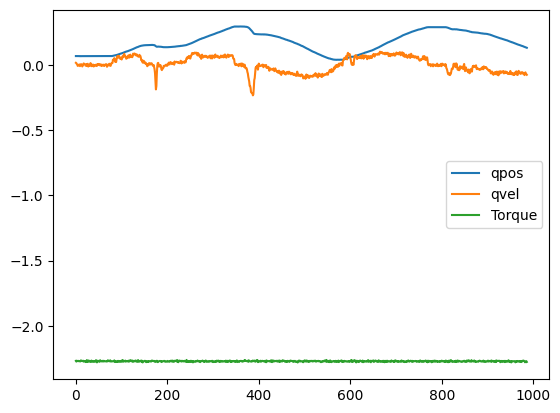

In [56]:
plt.plot(q_arr, label='qpos')
plt.plot(qd_arr, label='qvel')
plt.plot(Tau_arr, label='Torque')
plt.legend()